In [48]:
import pandas as pd
import numpy as np

from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score

from sklearn.model_selection import GridSearchCV

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

import seaborn as sns


In [126]:
df = pd.read_parquet("df_preprocessed_windows.parquet")

#split:
train_cycles = ["B1", "B2"]
val_cycles   = ["A1"]
test_cycles  = ["A2"]

df_train = df[df["cycle_id"].isin(train_cycles)].copy()
df_val   = df[df["cycle_id"].isin(val_cycles)].copy()
df_test  = df[df["cycle_id"].isin(test_cycles)].copy()

print("Train size:", df_train.shape)
print("Val size:", df_val.shape)
print("Test size:", df_test.shape)
print("Positive rates:",
      df_train["label"].mean(),
      df_val["label"].mean(),
      df_test["label"].mean())


Train size: (5448, 28)
Val size: (4524, 28)
Test size: (4077, 28)
Positive rates: 0.06167400881057269 0.03713527851458886 0.041206769683590876


In [127]:
feature_cols = [
    c for c in df.columns
    if c not in ["pump_id", "cycle_id", "end_time", "label"]
]

X_train = df_train[feature_cols]
y_train = df_train["label"]

X_val = df_val[feature_cols]
y_val = df_val["label"]

X_test = df_test[feature_cols]
y_test = df_test["label"]

In [128]:
lr_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [129]:

# Validation
y_val_pred  = lr_pipe.predict(X_val)
y_val_proba = lr_pipe.predict_proba(X_val)[:, 1]

print("\n=== VALIDATION RESULTS ===")
print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("PR-AUC :", average_precision_score(y_val, y_val_proba))

# Test
y_test_pred  = lr_pipe.predict(X_test)
y_test_proba = lr_pipe.predict_proba(X_test)[:, 1]

print("\n=== TEST RESULTS ===")
print(classification_report(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("PR-AUC :", average_precision_score(y_test, y_test_proba))



=== VALIDATION RESULTS ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4356
           1       0.44      0.07      0.12       168

    accuracy                           0.96      4524
   macro avg       0.70      0.53      0.55      4524
weighted avg       0.95      0.96      0.95      4524

ROC-AUC: 0.8184564803882985
PR-AUC : 0.2813392339784472

=== TEST RESULTS ===
              precision    recall  f1-score   support

           0       0.94      0.63      0.76      3909
           1       0.00      0.00      0.00       168

    accuracy                           0.61      4077
   macro avg       0.47      0.32      0.38      4077
weighted avg       0.90      0.61      0.72      4077

ROC-AUC: 0.10201275444943902
PR-AUC : 0.023175064819173745


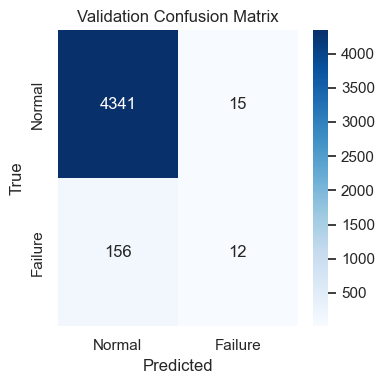

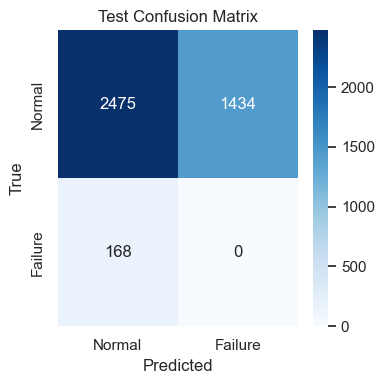

In [130]:
nd build from that: 

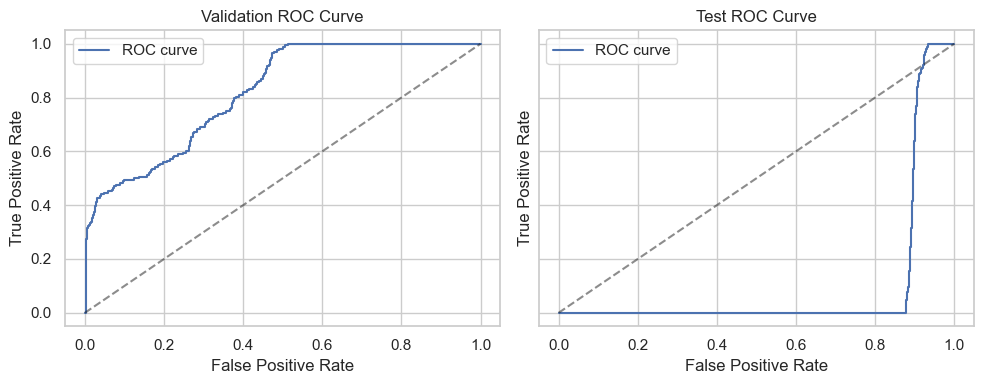

In [131]:
from sklearn.metrics import roc_curve

def plot_roc(y_true, y_proba, title, ax):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    ax.plot(fpr, tpr, label="ROC curve")
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend()

# create one figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)


plot_roc(y_val, y_val_proba, "Validation ROC Curve", axes[0])
plot_roc(y_test, y_test_proba, "Test ROC Curve", axes[1])

plt.tight_layout()
plt.show()

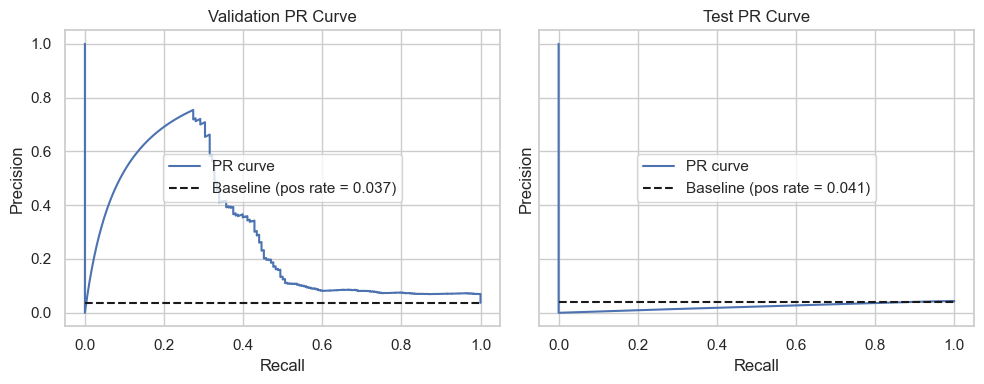

In [132]:
from sklearn.metrics import precision_recall_curve

def plot_pr(y_true, y_proba, title, ax):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    baseline = y_true.mean()

    ax.plot(recall, precision, label="PR curve")
    ax.hlines(
        baseline, 0, 1,
        colors="k",
        linestyles="dashed",
        label=f"Baseline (pos rate = {baseline:.3f})"
    )
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.legend(loc="center")

# one figure, two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_pr(y_val, y_val_proba, "Validation PR Curve", axes[0])
plot_pr(y_test, y_test_proba, "Test PR Curve", axes[1])

plt.tight_layout()
plt.show()


In [139]:
print(df.keys())

Index(['pump_id', 'end_time', 'label', 'delta_p_mean', 'delta_p_std',
       'delta_p_trend', 'active_pressure_fraction', 'output_mean',
       'output_std', 'output_trend', 'suction_mean', 'suction_std',
       'discharge_mean', 'discharge_std', 'flow_primary_mean',
       'flow_total_mean', 'tank_level_mean', 'tank_level_std', 'dm1_mean',
       'dm1_std', 'dm2_mean', 'dm2_std', 'dm3_mean', 'dm3_std', 'pc1_fraction',
       'pc2_fraction', 'pc3_fraction', 'cycle_id'],
      dtype='object')


In [150]:
#== checking feature distributions per cycle:

FEATURES_TO_CHECK = [
    "delta_p_mean",
    "output_mean",
    "active_pressure_fraction",
]


In [151]:


summary = (
    df
    .groupby("cycle_id")[FEATURES_TO_CHECK]
    .agg(["mean", "std", "min", "max"])
    .round(3)
)

summary


delta_p_mean                      output_mean                         \
                 mean    std    min    max        mean    std     min     max   
cycle_id                                                                        
A1              3.609  0.619  0.856  5.241      36.274  5.122  12.949  46.817   
A2              3.206  1.309 -0.986  5.447      36.902  7.536  19.354  49.472   
B1              3.357  0.591  2.381  4.413      36.521  5.939  27.563  48.228   
B2              3.915  0.836  1.653  5.046      42.393  6.490  29.739  56.544   
B3              2.333  0.728  1.135  3.828      27.890  5.054  18.035  39.103   

         active_pressure_fraction                       
                             mean    std    min    max  
cycle_id                                                
A1                          0.245  0.087  0.000  0.500  
A2                          0.162  0.098  0.000  0.385  
B1                          0.216  0.056  0.111  0.315  
B2                          0.266  0.111  0.007  0.430  
B3                          0.081  0.058  0.012  0.196

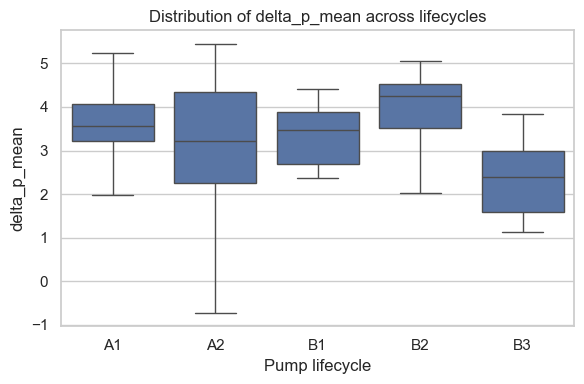

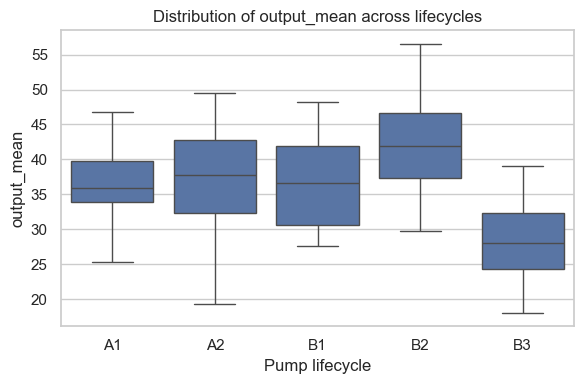

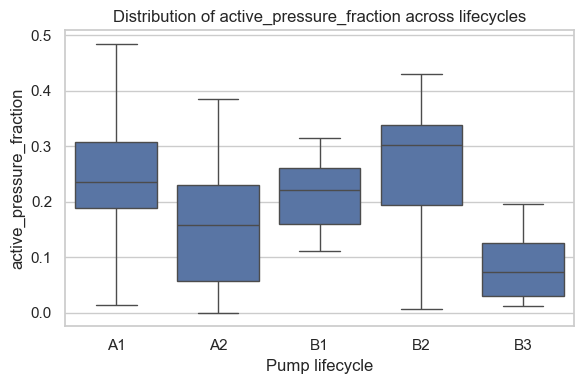

In [166]:


sns.set(style="whitegrid")

for feature in FEATURES_TO_CHECK:
    plt.figure(figsize=(6,4))
    sns.boxplot(
        data=df,
        x="cycle_id",
        y=feature,
        showfliers=False
    )
    plt.title(f"Distribution of {feature} across lifecycles")
    plt.xlabel("Pump lifecycle")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


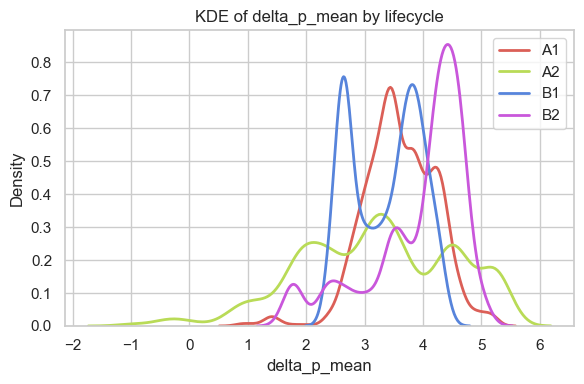

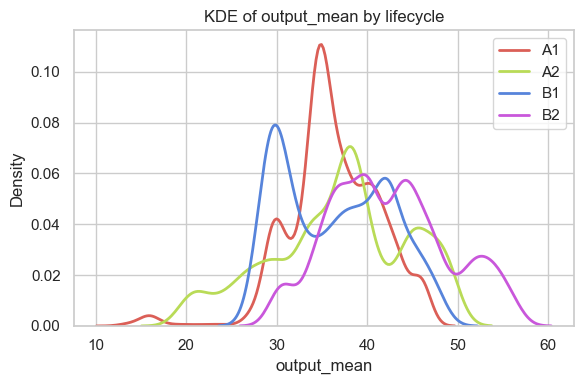

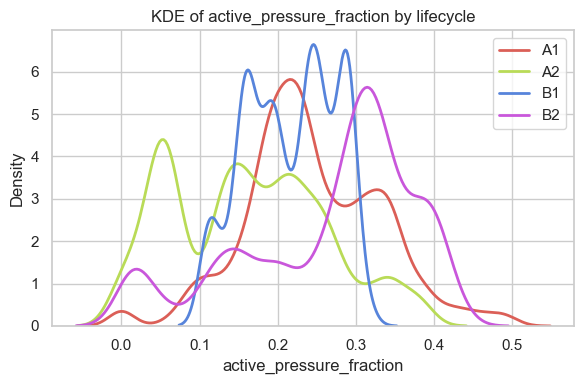

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in ["delta_p_mean", "output_mean", "active_pressure_fraction"]:
    plt.figure(figsize=(6, 4))

    # high-contrast, colorblind-safe palette
    palette = sns.color_palette("hls", n_colors=df["cycle_id"].nunique())

    for cid, color in zip(df["cycle_id"].unique(), palette):
        sns.kdeplot(
            df[df["cycle_id"] == cid][feature],
            label=cid,
            color=color,
            fill=False,
            linewidth=2
        )

    plt.title(f"KDE of {feature} by lifecycle")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()
